In [1]:
from plots.mpltoolkit import named_colors, mpl_loc, markers, fancy_legend, load_mpl_presets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import vice
import sys
sys.path.append("..")
from src.stats import skewnormal_mode_sample, jackknife_summary_statistic
load_mpl_presets()
mpl.rcParams["axes.linewidth"] = 0.5
mpl.rcParams["figure.titlesize"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14
mpl.rcParams["legend.fontsize"] = 14
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=13, releaselevel='final', serial=0)


In [2]:
columns = ["LINE", "APOGEE_ID", "RA", "DEC", "GALR", "GALPHI", "GALZ", "SNREV", "TEFF", "TEFF_ERR",
    "LOGG", "LOGG_ERR", "FE_H", "FE_H_ERR", "O_FE", "O_FE_ERR", "ASTRONN_AGE", "ASTRONN_AGE_ERR",
    "LATENT_AGE", "LATENT_AGE_ERR"]
raw = np.genfromtxt("../data/Leung2023.csv", delimiter = ',', skip_header = 1, usecols = range(len(columns)))
sample = {}
for i in range(len(columns)):
    sample[columns[i]] = [row[i] for row in raw]
sample["o_h"] = [a + b for a, b in zip(sample["O_FE"], sample["FE_H"])]
sample["o_h_err"] = [np.sqrt(a**2 + b**2) for a, b in zip(sample["O_FE_ERR"], sample["FE_H_ERR"])]
sample["absz"] = [abs(_) for _ in sample["GALZ"]]
sample = vice.dataframe(sample)
sample = sample.filter("absz", "<=", 0.5)
print(sample)

vice.dataframe{
    line -----------> [0, 1, 2, ... , 192917, 192918, 192919]
    apogee_id ------> [nan, nan, nan, ... , nan, nan, nan]
    ra -------------> [0.00285, 0.005558, 0.008802, ... , 359.993, 359.995, 359.997]
    dec ------------> [57.1732, 57.3545, 63.4631, ... , 57.0124, 57.435, 56.1633]
    galr -----------> [8.4584, 11.9539, 12.8583, ... , 10.6942, 9.3281, 9.64501]
    galphi ---------> [175.658, 153.655, 151.397, ... , 159.022, 167.511, 165.095]
    galz -----------> [-0.040749, -0.470835, 0.169356, ... , -0.358826, -0.163006, -0.265258]
    snrev ----------> [282.746, 120.295, 169.02, ... , 101.537, 232.918, 88.4561]
    teff -----------> [5031.26, 4974.6, 4681.46, ... , 4954.17, 4859.91, 4585.41]
    teff_err -------> [10.1451, 15.3109, 8.76634, ... , 15.7503, 9.05073, 11.2989]
    logg -----------> [3.45613, 2.38825, 2.24553, ... , 2.47466, 2.48069, 2.57144]
    logg_err -------> [0.0235541, 0.0355173, 0.0243345, ... , 0.0347484, 0.0240131, 0.0286862]
    fe_h ----

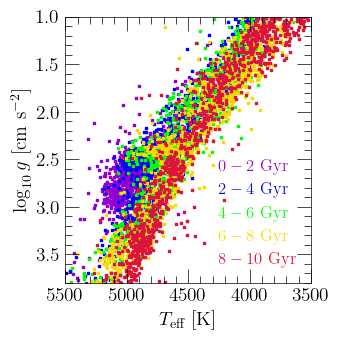

In [16]:
AGE_BINS = [0, 2, 4, 6, 8, 10]
COLORS = ["darkviolet", "blue", "lime", "gold", "crimson"]
N_SAMPLE = 1000
SEED = 1

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$T_\text{eff}$ [K]")
ax.set_ylabel(r"$\log_{10} g$ [cm s$^{-2}$]")
ax.set_xlim([3500, 5500])
ax.set_ylim([1, 3.8])
ax.invert_xaxis()
ax.invert_yaxis()

random.seed(a = SEED)
for i in range(len(AGE_BINS) - 1):
    sub = sample.filter(
        "astronn_age", ">=", AGE_BINS[i]).filter(
        "astronn_age", "<=", AGE_BINS[i + 1])
    indices = random.sample(range(len(sub["teff"])), N_SAMPLE)
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "s": 1,
        "marker": markers()["pixel"],
        "rasterized": True,
        "label": r"$%d - %d$ Gyr" % (AGE_BINS[i], AGE_BINS[i + 1])
    }
    teff = [sub["teff"][idx] for idx in indices]
    logg = [sub["logg"][idx] for idx in indices]
    ax.scatter(teff, logg, **kwargs)

kwargs = {
    "loc": mpl_loc("lower right"),
    "handlelength": 0,
    "fontsize": 12,
    "ncol": 1
}
leg = ax.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./empirical/kiel-diagram.%s" % (ext), **kwargs)
plt.show()

In [23]:
OUTFILE = "./empirical/skewnormfits.out"
RGAL_BINS = list(range(16))
AGE_BINS = list(range(11))
MIN_STARS = 200

with open(OUTFILE, 'w') as out:
    out.write("# age_min [Gyr]    age_max [Gyr]    ")
    out.write("Rgal_min [kpc]    Rgal_max [kpc]    ")
    out.write("mode([O/H])    mode([O/H])_err    ")
    out.write("mode([Fe/H])    mode([Fe/H])_err\n")
    for i in range(len(AGE_BINS) - 1):
        sub = sample.filter(
            "astronn_age", ">=", AGE_BINS[i]).filter(
            "astronn_age", "<=", AGE_BINS[i + 1])
        for j in range(len(RGAL_BINS) - 1):
            subsub = sub.filter(
                "galr", ">=", RGAL_BINS[j]).filter(
                "galr", "<=", RGAL_BINS[j + 1])
            sys.stdout.write("\ri = %d ; j = %d    " % (i, j))
            if len(subsub["o_h"]) >= MIN_STARS:
                mode_oh = skewnormal_mode_sample(subsub["o_h"])
                mode_feh = skewnormal_mode_sample(subsub["fe_h"])
                mode_oh_err = jackknife_summary_statistic(subsub["o_h"], skewnormal_mode_sample, n_resamples = 25)
                mode_feh_err = jackknife_summary_statistic(subsub["fe_h"], skewnormal_mode_sample, n_resamples = 25)
            else:
                mode_oh = mode_oh_err = mode_feh = mode_feh_err = float("nan")
            out.write("%.3e\t%.3e\t" % (AGE_BINS[i], AGE_BINS[i + 1]))
            out.write("%.3e\t%.3e\t" % (RGAL_BINS[j], RGAL_BINS[j + 1]))
            out.write("%.3e\t%.3e\t" % (mode_oh, mode_oh_err))
            out.write("%.3e\t%.3e\n" % (mode_feh, mode_feh_err))
    sys.stdout.write("\n")
    out.close()

i = 9 ; j = 14    


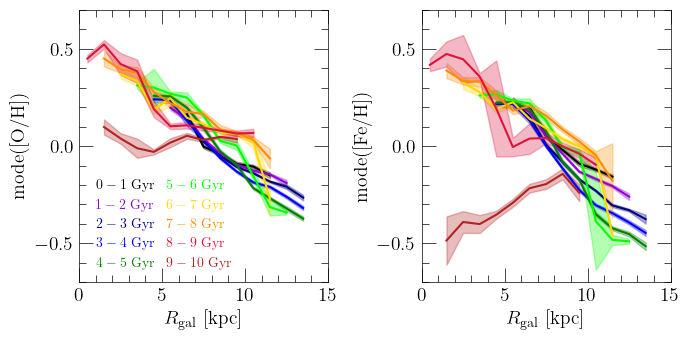

In [4]:
OUTFILE = "./empirical/skewnormfits.out"
RGAL_BINS = list(range(16))
AGE_BINS = list(range(11))
COLORS = ["black", "darkviolet", "navy", "blue", "green",
    "lime", "gold", "darkorange", "crimson", "firebrick"]

fig = plt.figure(figsize = (7, 3.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for ax in [ax1, ax2]:
    ax.set_xlabel(r"$R_\text{gal}$ [kpc]", fontsize = 14)
    ax.set_xlim([0, 15])
    ax.set_xticks([0, 5, 10, 15])
    ax.set_ylim([-0.7, 0.7])
    ax.set_yticks([-0.5, 0, 0.5])
ax1.set_ylabel(r"mode([O/H])", fontsize = 14)
ax2.set_ylabel(r"mode([Fe/H])", fontsize = 14)

raw = np.genfromtxt(OUTFILE)
for i in range(len(AGE_BINS) - 1):
    sub = []
    for row in raw:
        if row[0] == AGE_BINS[i] and row[1] == AGE_BINS[i + 1]: sub.append(row)
    rgal_min = [row[2] for row in sub]
    rgal_max = [row[3] for row in sub]
    centers = [(a + b) / 2 for a, b in zip(rgal_min, rgal_max)]
    mode_oh = [row[4] for row in sub]
    mode_oh_err = [row[5] for row in sub]
    mode_feh = [row[6] for row in sub]
    mode_feh_err = [row[7] for row in sub]
    kwargs = {
        "color": named_colors()[COLORS[i]],
        "alpha": 0.3
    }
    ax1.fill_between(centers, [a - b for a, b in zip(mode_oh, mode_oh_err)],
        [a + b for a, b in zip(mode_oh, mode_oh_err)], **kwargs)
    ax2.fill_between(centers, [a - b for a, b in zip(mode_feh, mode_feh_err)],
        [a + b for a, b in zip(mode_feh, mode_feh_err)], **kwargs)
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": r"$%g - %g$ Gyr" % (AGE_BINS[i], AGE_BINS[i + 1])
    }
    ax1.plot(centers, mode_oh, **kwargs)
    ax2.plot(centers, mode_feh, **kwargs)

kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0,
    "ncol": 2,
    "fontsize": 10,
    "columnspacing": 0.5
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./empirical/gradxh-binned-by-age.%s" % (ext), **kwargs)
plt.show()